=SplitDataSet=
x_train shape: (712, 6)
y_train shape: (712, 1)
x_val shape: (179, 6)
y_val shape: (179, 1)
==initialize_parameters==
W_input shape (30, 6)
b_input shape (30, 1)
W_output shape (1, 30)
b_output shape (1, 1)
epoch:100, Train Loss:0.29, Acc:0.39, Val Loss:0.29, Acc:0.39
epoch:200, Train Loss:0.27, Acc:0.39, Val Loss:0.26, Acc:0.36
epoch:300, Train Loss:0.25, Acc:0.60, Val Loss:0.25, Acc:0.60
epoch:400, Train Loss:0.24, Acc:0.61, Val Loss:0.24, Acc:0.60
epoch:500, Train Loss:0.24, Acc:0.61, Val Loss:0.24, Acc:0.60
epoch:600, Train Loss:0.23, Acc:0.62, Val Loss:0.23, Acc:0.60
epoch:700, Train Loss:0.23, Acc:0.63, Val Loss:0.23, Acc:0.61
epoch:800, Train Loss:0.23, Acc:0.64, Val Loss:0.23, Acc:0.63
epoch:900, Train Loss:0.23, Acc:0.65, Val Loss:0.23, Acc:0.63
epoch:1000, Train Loss:0.23, Acc:0.64, Val Loss:0.22, Acc:0.63
epoch:1100, Train Loss:0.22, Acc:0.64, Val Loss:0.22, Acc:0.63
epoch:1200, Train Loss:0.22, Acc:0.64, Val Loss:0.22, Acc:0.64
epoch:1300, Train Loss:0.22, Ac

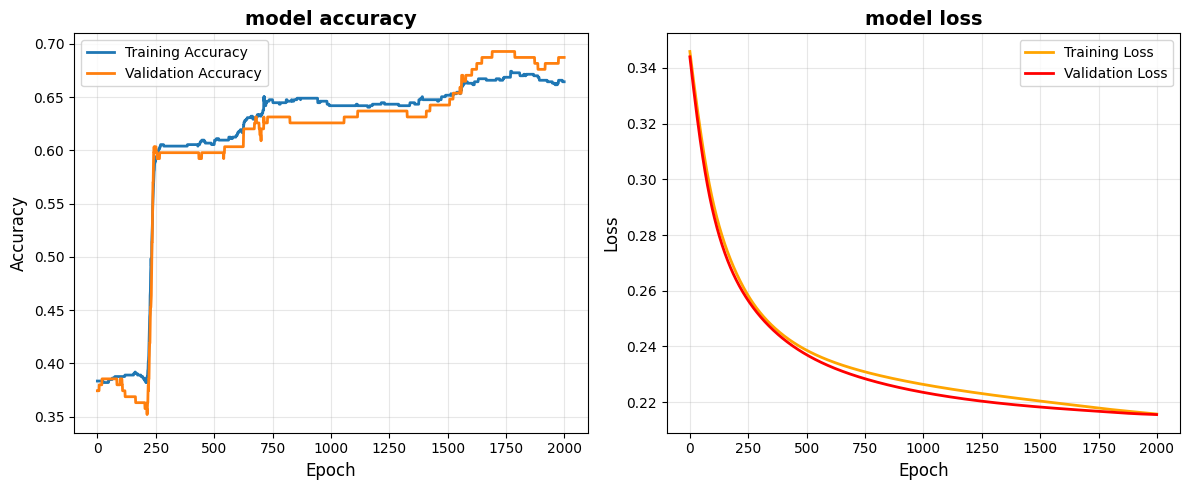


=== 最終訓練結果 ===
訓練集準確率: 0.6643 (66.43%)
驗證集準確率: 0.6872 (68.72%)
訓練集損失: 0.2157
驗證集損失: 0.2155


In [8]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

def SplitDataSet(DataSet, TargetName='Survived', SplitRate=0.8):
    """
    將資料集切分為訓練集和驗證集
    
    參數:
        DataSet: pandas DataFrame，完整的資料集
        TargetName: str，目標變數的欄位名稱（預測標籤）
        SplitRate: float，訓練集占總資料的比例（預設 0.8 即 80%）
    
    返回:
        x_train: 訓練特徵 (特徵矩陣)
        y_train: 訓練標籤 (目標值)
        x_val: 驗證特徵
        y_val: 驗證標籤
    """
    num_example = DataSet.shape[0]  # 取得資料總筆數

    # Shuffle - 隨機打亂資料順序，避免資料本身的排序影響訓練
    arr = np.arange(num_example)  # 產生 0 到 num_example-1 的索引陣列
    np.random.shuffle(arr)  # 隨機打亂索引
    DataSet = DataSet.iloc[arr]  # 根據打亂的索引重新排列資料
    DataSet = DataSet.reset_index(drop=True)  # 重設索引，避免索引錯亂

    # Split - 切分資料集
    s = int(num_example * SplitRate)  # 計算訓練集的資料筆數
    train = DataSet.iloc[0:s]  # 前 s 筆作為訓練集
    val = DataSet.iloc[s:]  # 剩餘的作為驗證集
    
    # 分離特徵 (X) 和標籤 (y)
    x_train = train.loc[0:, train.columns != TargetName].values  # 訓練特徵：排除目標欄位
    y_train = train.loc[0:, TargetName].values.reshape(-1, 1)  # 訓練標籤：只取目標欄位，並轉為列向量
    x_val = val.loc[0:, val.columns != TargetName].values  # 驗證特徵
    y_val = val.loc[0:, TargetName].values.reshape(-1, 1)  # 驗證標籤

    # 顯示各資料集的維度資訊
    print('=SplitDataSet=')
    print('x_train shape:', x_train.shape)  # 例如: (712, 6) 表示 712 筆資料，6 個特徵
    print('y_train shape:', y_train.shape)  # 例如: (712, 1)
    print('x_val shape:', x_val.shape)
    print('y_val shape:', y_val.shape)

    return x_train, y_train, x_val, y_val

def ComputeMeanStd(x):
    """
    計算特徵的平均值和標準差
    
    參數:
        x: numpy array，特徵矩陣
    
    返回:
        mean: 各特徵的平均值
        std: 各特徵的標準差
    
    說明:
        axis=0 表示沿著「列」方向計算，即對每個特徵（欄位）分別計算
    """
    mean = np.mean(x, axis=0)  # 計算每個特徵的平均值
    std = np.std(x, axis=0)  # 計算每個特徵的標準差
    return mean, std

def FeatureNormalization(x, mean, std):
    """
    特徵標準化 (Z-score Normalization)
    
    參數:
        x: numpy array，原始特徵矩陣
        mean: 各特徵的平均值
        std: 各特徵的標準差
    
    返回:
        nor_x: 標準化後的特徵矩陣
    
    說明:
        標準化公式: (x - mean) / std
        標準化後的資料平均值為 0，標準差為 1
        目的是讓不同尺度的特徵在相同的數值範圍內，避免某些特徵主導訓練過程
    """
    nor_x = (x - mean) / std
    return nor_x

def initialize_parameters(num_input, num_hidden, num_output):
    """
    初始化神經網路的權重和偏置參數
    
    參數:
        num_input: int，輸入層神經元數量（特徵數量）
        num_hidden: int，隱藏層神經元數量
        num_output: int，輸出層神經元數量（分類任務通常為 1）
    
    返回:
        parameters: dict，包含所有初始化的參數
    
    說明:
        - 權重 (W) 使用隨機初始化：避免對稱性問題，讓神經元學習到不同的特徵
        - 偏置 (b) 初始化為 0：偏置的初始值對訓練影響較小
        - 權重矩陣維度: (輸出神經元數, 輸入神經元數)
    """
    # 輸入層 -> 隱藏層的參數（使用 Xavier 初始化減少數值溢出）
    W_input = np.random.randn(num_hidden, num_input) * np.sqrt(1.0 / num_input)  # 權重矩陣，形狀: (隱藏層, 輸入層)
    b_input = np.zeros(shape=(num_hidden, 1))  # 偏置向量，形狀: (隱藏層, 1)
    
    # 隱藏層 -> 輸出層的參數（使用 Xavier 初始化）
    W_output = np.random.randn(num_output, num_hidden) * np.sqrt(1.0 / num_hidden)  # 權重矩陣，形狀: (輸出層, 隱藏層)
    b_output = np.zeros(shape=(num_output, 1))  # 偏置向量，形狀: (輸出層, 1)

    # 顯示參數維度資訊，方便除錯
    print('==initialize_parameters==')
    print('W_input shape', W_input.shape)
    print('b_input shape', b_input.shape)
    print('W_output shape', W_output.shape)
    print('b_output shape', b_output.shape)

    # 使用 assert 檢查維度是否正確
    assert (W_input.shape == (num_hidden, num_input))
    assert (b_input.shape == (num_hidden, 1))
    assert (W_output.shape == (num_output, num_hidden))
    assert (b_output.shape == (num_output, 1))

    # 將所有參數打包成字典
    parameters = {"W_input": W_input,
                  "b_input": b_input,
                  "W_output": W_output,
                  "b_output": b_output}
    
    return parameters

def activate(z, fun):
    """
    激活函數：為神經網路引入非線性
    
    參數:
        z: numpy array，線性組合的結果 (Z = W*X + b)
        fun: str，激活函數的類型
    
    返回:
        s: 經過激活函數處理後的結果
    
    說明:
        - ReLU: 當 z > 0 時輸出 z，否則輸出 0。計算快速，是最常用的激活函數
        - tanh: 雙曲正切函數，輸出範圍在 [-1, 1]。適合隱藏層使用
        - Leaky ReLU: ReLU 的改進版，負值部分保留小幅度的斜率 (0.01*z)
    """
    if(fun == 'relu'):
        s = np.where(z > 0, z, 0)  # ReLU: max(0, z)
    elif(fun == 'tanh'):
        s = np.tanh(z)  # 使用 numpy 內建的 tanh，更穩定
    elif(fun == 'leakyRelu'):
        s = np.where(z > 0, z, z * 0.01)  # Leaky ReLU: z if z>0 else 0.01*z
    return s

def sigmoid(z):
    """
    Sigmoid 激活函數
    
    參數:
        z: numpy array，輸入值
    
    返回:
        s: Sigmoid 函數的輸出，範圍在 (0, 1) 之間
    
    說明:
        公式: σ(z) = 1 / (1 + e^(-z))
        - 輸出值可解釋為「機率」
        - 常用於二元分類問題的輸出層
        - 當 z 很大時，輸出接近 1；當 z 很小時，輸出接近 0
    """
    s = 1 / (1 + np.exp(-z))
    return s

def forward_propagation(X, parameters):
    """
    前向傳播：計算神經網路的預測輸出
    
    參數:
        X: numpy array，輸入資料，形狀為 (特徵數, 樣本數)
        parameters: dict，包含權重和偏置的字典
    
    返回:
        A_output: 網路的最終輸出（預測值），形狀為 (1, 樣本數)
        cache: dict，儲存中間計算結果，供反向傳播使用
    
    說明:
        前向傳播流程:
        1. 輸入層 -> 隱藏層: Z = W*X + b，然後 A = tanh(Z)
        2. 隱藏層 -> 輸出層: Z = W*A + b，然後 A = sigmoid(Z)
        
        符號說明:
        - Z: 線性組合的結果（未經激活函數處理）
        - A: 經過激活函數處理後的結果（Activation）
    """
    # 取出參數
    W_input = parameters['W_input']  # 輸入層到隱藏層的權重
    b_input = parameters['b_input']  # 隱藏層的偏置
    W_output = parameters['W_output']  # 隱藏層到輸出層的權重
    b_output = parameters['b_output']  # 輸出層的偏置

    # 第一層：輸入層 -> 隱藏層
    Z_input = np.dot(W_input, X) + b_input  # 線性變換: Z = W*X + b
    A_input = activate(Z_input, 'tanh')  # 激活函數: A = tanh(Z)

    # 第二層：隱藏層 -> 輸出層
    Z_output = np.dot(W_output, A_input) + b_output  # 線性變換
    A_output = sigmoid(Z_output)  # Sigmoid 激活：將輸出壓縮到 (0, 1)

    # 檢查輸出維度是否正確
    assert(A_output.shape == (1, X.shape[1]))  # 應為 (1, 樣本數)

    # 將中間結果存入 cache，供反向傳播時使用
    cache = {"Z_input": Z_input,
             "A_input": A_input,
             "Z_output": Z_output,
             "A_output": A_output}

    return A_output, cache

def backward_propagation(parameters, cache, X, Y):
    """
    反向傳播：計算損失函數對各參數的梯度
    
    參數:
        parameters: dict，包含權重和偏置
        cache: dict，前向傳播時儲存的中間結果
        X: numpy array，輸入資料
        Y: numpy array，真實標籤
    
    返回:
        grads: dict，包含所有參數的梯度
    
    說明:
        反向傳播是神經網路學習的核心！
        它使用微積分的鏈式法則 (Chain Rule)，從輸出層開始，
        逐層計算損失函數對每個參數的偏導數（梯度）。
        
        梯度告訴我們：「參數應該往哪個方向調整，才能讓損失變小」
        
        計算流程（由後往前）:
        1. 輸出層梯度: dZ_output = A_output - Y
        2. 輸出層權重梯度: dW_output = (1/m) * dZ_output * A_input^T
        3. 隱藏層梯度: dZ_input = W_output^T * dZ_output * (1 - A_input^2)
           註: (1 - A_input^2) 是 tanh 的導數
        4. 隱藏層權重梯度: dW_input = (1/m) * dZ_input * X^T
    """
    m = X.shape[1]  # 樣本數量，用於計算平均梯度

    # 取出參數和中間結果
    W_input = parameters['W_input']
    W_output = parameters['W_output']
    A_input = cache['A_input']  # 隱藏層的激活值
    A_output = cache['A_output']  # 輸出層的激活值（預測值）

    # === 輸出層的梯度計算 ===
    # dZ_output: 損失對 Z_output 的梯度（對於 MSE + Sigmoid，梯度就是預測值減真實值）
    dZ_output = (A_output - Y)
    
    # dW_output: 損失對 W_output 的梯度
    # 公式: (1/m) * dZ_output * A_input^T
    dW_output = (1 / m) * np.dot(dZ_output, A_input.T)
    
    # db_output: 損失對 b_output 的梯度
    # 公式: (1/m) * sum(dZ_output)
    db_output = (1 / m) * np.sum(dZ_output, axis=1, keepdims=True)

    # === 隱藏層的梯度計算 ===
    # dZ_input: 損失對 Z_input 的梯度
    # 公式: W_output^T * dZ_output * tanh'(Z_input)
    # 其中 tanh 的導數為: 1 - tanh^2(Z) = 1 - A_input^2
    dZ_input = np.multiply(np.dot(W_output.T, dZ_output), 1 - np.power(A_input, 2))
    
    # dW_input: 損失對 W_input 的梯度
    dW_input = (1 / m) * np.dot(dZ_input, X.T)
    
    # db_input: 損失對 b_input 的梯度
    db_input = (1 / m) * np.sum(dZ_input, axis=1, keepdims=True)

    # 將所有梯度打包成字典
    grads = {"dW_input": dW_input,
             "db_input": db_input,
             "dW_output": dW_output,
             "db_output": db_output}

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    參數更新：使用梯度下降法更新網路參數
    
    參數:
        parameters: dict，當前的權重和偏置
        grads: dict，各參數的梯度
        learning_rate: float，學習率（步長）
    
    返回:
        parameters: dict，更新後的參數
    
    說明:
        梯度下降法的核心公式: θ_new = θ_old - α * ∇θ
        - θ: 參數（權重或偏置）
        - α: 學習率，控制每次更新的幅度
        - ∇θ: 梯度，指向損失增加最快的方向
        
        學習率的影響:
        - 太大：可能錯過最優解，訓練不穩定
        - 太小：訓練速度慢，容易卡在局部最優
        - 典型值: 0.001 ~ 0.1
    """
    # 取出當前參數
    W_input = parameters['W_input']
    b_input = parameters['b_input']
    W_output = parameters['W_output']
    b_output = parameters['b_output']

    # 取出梯度
    dW_input = grads['dW_input']
    db_input = grads['db_input']
    dW_output = grads['dW_output']
    db_output = grads['db_output']

    # 梯度下降：沿著梯度的反方向更新參數
    W_input = W_input - learning_rate * dW_input
    b_input = b_input - learning_rate * db_input
    W_output = W_output - learning_rate * dW_output
    b_output = b_output - learning_rate * db_output

    # 打包更新後的參數
    parameters = {"W_input": W_input,
                  "b_input": b_input,
                  "W_output": W_output,
                  "b_output": b_output}

    return parameters

def compute_loss(Y, A_output, parameters):
    """
    計算損失函數（Loss Function）
    
    參數:
        Y: numpy array，真實標籤
        A_output: numpy array，模型預測值
        parameters: dict，模型參數（此處未使用，但保留以便擴展）
    
    返回:
        loss: float，損失值
    
    說明:
        損失函數用來衡量「模型預測值與真實值的差距」
        這裡使用 MSE (Mean Squared Error，均方誤差):
        MSE = (1/N) * Σ(預測值 - 真實值)^2
        
        損失越小，表示模型預測越準確
    """
    N = A_output.shape[1]  # 樣本數量

    # 計算均方誤差 (MSE)
    loss = np.square(A_output - Y).mean()
    # 另一個選擇: RMSE (均方根誤差) = sqrt(MSE)
    # loss = np.sqrt(((A_output - Y) ** 2).mean())

    # 確保 loss 是純量（float），而非 numpy array
    loss = float(np.squeeze(loss))
    assert(isinstance(loss, float))

    return loss

def predict(parameters, X):
    """
    使用訓練好的模型進行預測
    
    參數:
        parameters: dict，訓練好的權重和偏置
        X: numpy array，輸入資料
    
    返回:
        predictions: numpy array，二元分類結果（0 或 1）
    
    說明:
        預測流程:
        1. 執行前向傳播，得到輸出機率 A_output（0~1 之間）
        2. 設定閾值為 0.5：
           - 機率 >= 0.5 → 預測為 1（生存）
           - 機率 < 0.5 → 預測為 0（死亡）
    """
    N = X.shape[1]  # 樣本數量
    predictions = np.zeros((1, N))  # 初始化預測結果陣列
    
    # 執行前向傳播，得到輸出機率
    A_output, cache = forward_propagation(X, parameters)
    
    # 將機率轉換為二元分類結果（0 或 1）
    for i in range(A_output.shape[1]):
        predictions[0, i] = np.where(A_output[0, i] >= 0.5, 1, 0)

    # 檢查輸出維度
    assert(predictions.shape == (1, N))

    return predictions

def calculation_metrics(y_true, y_pred, Methods='acc'):
    """
    計算模型評估指標
    
    參數:
        y_true: numpy array，真實標籤
        y_pred: numpy array，預測結果
        Methods: str，評估指標類型
    
    返回:
        metric: float，評估指標的數值
    
    說明:
        - acc (Accuracy): 準確率 = 預測正確的樣本數 / 總樣本數
        - mse (Mean Squared Error): 均方誤差
        - rmse (Root Mean Squared Error): 均方根誤差
        - mae (Mean Absolute Error): 平均絕對誤差
    """
    if(Methods == 'acc'):
        return np.mean(y_true == y_pred)  # 準確率
    elif(Methods == 'mse'):
        return np.mean(np.square(y_true - y_pred))  # MSE
    elif(Methods == 'rmse'):
        return np.square(np.mean(np.square(y_true - y_pred)))  # RMSE
    elif(Methods == 'mae'):
        return np.mean(np.abs(y_true - y_pred))  # MAE

def TrainModel(x_train, y_train, x_val, y_val, num_hidden, num_iterations, learning_rate):
    """
    完整的模型訓練流程
    
    參數:
        x_train: 訓練特徵
        y_train: 訓練標籤
        x_val: 驗證特徵
        y_val: 驗證標籤
        num_hidden: int，隱藏層神經元數量
        num_iterations: int，訓練迭代次數（epoch）
        learning_rate: float，學習率
    
    返回:
        model: dict，包含訓練歷史和最終參數的字典
    
    說明:
        訓練流程（每個 epoch）:
        1. 前向傳播：計算預測值
        2. 計算損失：評估預測誤差
        3. 反向傳播：計算梯度
        4. 參數更新：使用梯度下降
        5. 評估指標：計算訓練集和驗證集的準確率
        
        訓練集 vs 驗證集:
        - 訓練集用於更新模型參數
        - 驗證集用於監控模型是否過擬合
        - 如果驗證損失開始上升，可能需要提前停止訓練
    """
    # 轉置數據到 (特徵數, 樣本數) 的格式
    x_train = x_train.T
    y_train = y_train.T
    x_val = x_val.T
    y_val = y_val.T
    
    # 初始化記錄列表，用於追蹤訓練過程
    train_loss = []  # 訓練集損失
    val_loss = []  # 驗證集損失
    train_acc = []  # 訓練集準確率
    val_acc = []  # 驗證集準確率
    
    # 確定網路架構的輸入輸出維度
    num_input = x_train.shape[0]  # 特徵數量
    num_output = y_train.shape[0]  # 輸出數量（二元分類為 1）
    
    # 初始化網路參數（權重和偏置）
    parameters = initialize_parameters(num_input, num_hidden, num_output)
    
    # === 訓練迴圈：重複執行 num_iterations 次 ===
    for i in range(1, num_iterations+1):
        # === 1. 訓練集上的前向傳播和損失計算 ===
        A_output, cache = forward_propagation(x_train, parameters)  # 前向傳播
        train_loss_Temp = compute_loss(y_train, A_output, parameters)  # 計算損失
        
        # === 2. 反向傳播：計算梯度 ===
        grads = backward_propagation(parameters, cache, x_train, y_train)
        
        # === 3. 參數更新：使用梯度下降 ===
        parameters = update_parameters(parameters, grads, learning_rate)

        # === 4. 計算訓練集準確率 ===
        Y_prediction_train = predict(parameters, x_train)  # 在訓練集上預測
        train_acc_Temp = calculation_metrics(y_train, Y_prediction_train, Methods='acc')

        # === 5. 驗證集上的評估（不更新參數，只用於監控） ===
        val_A_output, val_cache = forward_propagation(x_val, parameters)
        val_loss_Temp = compute_loss(y_val, val_A_output, parameters)

        # === 6. 計算驗證集準確率 ===
        Y_prediction_val = predict(parameters, x_val)
        val_acc_Temp = calculation_metrics(y_val, Y_prediction_val, Methods='acc')

        # === 7. 記錄本次迭代的指標 ===
        train_loss.append(train_loss_Temp)
        val_loss.append(val_loss_Temp)
        train_acc.append(train_acc_Temp)
        val_acc.append(val_acc_Temp)

        # === 8. 每 100 次迭代顯示一次訓練進度 ===
        if(i % 100 == 0):
            print('epoch:%s, Train Loss:%.2f, Acc:%.2f, Val Loss:%.2f, Acc:%.2f'\
                  %(i, train_loss_Temp, train_acc_Temp,
                    val_loss_Temp, val_acc_Temp))

    # === 9. 訓練完成，打包所有結果 ===
    model = {"train_loss": train_loss,  # 訓練損失歷史
             "val_loss": val_loss,  # 驗證損失歷史
             "train_acc": train_acc,  # 訓練準確率歷史
             "val_acc": val_acc,  # 驗證準確率歷史
             "parameters": parameters,  # 訓練好的參數（最重要！）
             "learning_rate": learning_rate,  # 學習率
             "num_iterations": num_iterations}  # 迭代次數

    # === 10. 儲存模型到檔案 ===
    # 使用 pickle 將模型序列化，方便未來載入使用
    pickle.dump(model, open('model.pkl', 'wb'))
    return model

def main():
    """
    主函數：執行整個訓練流程
    """
    # 讀取訓練資料
    DataSet = pd.read_csv('./DataSet/train_dataset.csv')
    DataSet = DataSet.drop(['PassengerId'], axis=1)

    # 切分資料為訓練集和驗證集
    x_train, y_train, x_val, y_val = SplitDataSet(DataSet)
    
    # 設定訓練參數
    num_hidden = 30  # 隱藏層神經元數量
    num_iterations = 2000  # 訓練迭代次數
    learning_rate = 0.001  # 學習率（降低以提高穩定性）
    
    # 開始訓練
    model = TrainModel(x_train, y_train, x_val, y_val, num_hidden,
                       num_iterations=num_iterations, learning_rate=learning_rate)
    
    print("\n訓練完成！模型已儲存至 model.pkl")
    
    # === 繪製訓練過程的準確率變化圖 ===
    plt.figure(figsize=(12, 5))
    
    # 子圖1：準確率變化
    plt.subplot(1, 2, 1)
    plt.plot(model['train_acc'], label='Training Accuracy', linewidth=2)
    plt.plot(model['val_acc'], label='Validation Accuracy', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('model accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 子圖2：損失值變化
    plt.subplot(1, 2, 2)
    plt.plot(model['train_loss'], label='Training Loss', linewidth=2, color='orange')
    plt.plot(model['val_loss'], label='Validation Loss', linewidth=2, color='red')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('model loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("\n訓練曲線已儲存至 training_history.png")
    plt.show()
    
    # 顯示最終結果統計
    print(f"\n=== 最終訓練結果 ===")
    print(f"訓練集準確率: {model['train_acc'][-1]:.4f} ({model['train_acc'][-1]*100:.2f}%)")
    print(f"驗證集準確率: {model['val_acc'][-1]:.4f} ({model['val_acc'][-1]*100:.2f}%)")
    print(f"訓練集損失: {model['train_loss'][-1]:.4f}")
    print(f"驗證集損失: {model['val_loss'][-1]:.4f}")

if __name__ == "__main__":
    main()

In [6]:
# === 使用訓練好的 NumPy 模型進行測試預測 ===

import pickle

# 1. 加載訓練好的模型
model = pickle.load(open('model.pkl', 'rb'))
parameters = model['parameters']
print("模型已加載，訓練信息：")
print(f"  - 訓練迭代次數: {model['num_iterations']}")
print(f"  - 最終訓練準確率: {model['train_acc'][-1]:.4f}")
print(f"  - 最終驗證準確率: {model['val_acc'][-1]:.4f}")

# 2. 讀取測試資料
test_df = pd.read_csv('./DataSet/test_dataset.csv')
print(f"\n測試資料大小: {test_df.shape}")

# 3. 數據預處理（必須與訓練時完全一致）
# 選擇相同的特徵
test_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X_test = test_df[test_features].copy()

# 處理缺失值
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())

# 性別轉數字
if X_test['Sex'].dtype == 'object':
    X_test['Sex'] = X_test['Sex'].map({'male': 1, 'female': 0})

# 4. 特徵標準化（使用訓練時的平均值和標準差）
# 需要先從訓練資料計算統計值
train_df = pd.read_csv('./DataSet/train_dataset.csv')
train_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
X_train_original = train_df[train_features].copy()
X_train_original['Age'] = X_train_original['Age'].fillna(X_train_original['Age'].mean())
X_train_original['Fare'] = X_train_original['Fare'].fillna(X_train_original['Fare'].mean())
if X_train_original['Sex'].dtype == 'object':
    X_train_original['Sex'] = X_train_original['Sex'].map({'male': 1, 'female': 0})

mean, std = ComputeMeanStd(X_train_original.values)
X_test_normalized = FeatureNormalization(X_test.values, mean, std)

# 5. 轉置為 (特徵數, 樣本數) 的格式
X_test_normalized = X_test_normalized.T

# 6. 進行預測
predictions = predict(parameters, X_test_normalized)
predictions = predictions.flatten()

# 7. 整合結果並輸出 CSV
result_df = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": predictions.astype(int)
})

result_df.to_csv('numpy_predictions.csv', index=False)
print(f"\n預測完成！結果已儲存至 numpy_predictions.csv")
print(f"\n預測結果摘要（前 10 筆）：")
print(result_df.head(10))
print(f"\n生存人數統計：")
print(result_df['Survived'].value_counts())

模型已加載，訓練信息：
  - 訓練迭代次數: 2000
  - 最終訓練準確率: 0.7079
  - 最終驗證準確率: 0.6872

測試資料大小: (418, 7)

預測完成！結果已儲存至 numpy_predictions.csv

預測結果摘要（前 10 筆）：
   PassengerId  Survived
0          892         1
1          893         0
2          894         0
3          895         1
4          896         0
5          897         1
6          898         1
7          899         0
8          900         1
9          901         0

生存人數統計：
Survived
1    264
0    154
Name: count, dtype: int64
